In [1]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map

from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


In [2]:
figformat = 'svg'

In [3]:
import json
with open("config.json") as json_data_file:
    config = json.load(json_data_file)
config = config['local']
print(config)
source = 'Crab'
path = config["path"]
path_crab = config["path_crab"]


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

dataset_load.models = models
dataset_load.counts = dataset_load.npred()

{'path': '/home/katrin/Documents', 'path_crab': '/home/katrin/Documents/Crab'}


In [27]:
biass = [0.2]
sigmass = [0]
zero = 1e-12
sigma_assumed = zero

In [40]:
def create_dataset(b, s):
    sys_d_cor = sys_dataset(dataset_asimov= dataset_load,
                        shift = 0,
                        tilt = 0,
                        bias = b, 
                        sigma = s,
                        rnd = False)
    dataset_conv = sys_d_cor.create_dataset()
    dataset_conv_N = sys_d_cor.create_dataset_N()
    dataset_conv_N.models.parameters['norm_nuisance'].frozen  = True
    dataset_conv_N.models.parameters['tilt_nuisance'].frozen  = True
    dataset_conv_N.models.parameters['resolution'].frozen  = True
    dataset_conv_N.models.parameters['bias'].frozen  = False
    #dataset_conv_N.models.parameters['resolution'].value  = s
    

    penalising_invcovmatrix = np.zeros((4, 4))
    if b ==0 :
        b_ = zero
    else:
        b_ = b
    np.fill_diagonal(penalising_invcovmatrix, [1/zero**2, 1/zero**2, 1/b_**2, 1/sigma_assumed**2])
    dataset_conv_N.penalising_invcovmatrix = penalising_invcovmatrix
    return dataset_conv, dataset_conv_N

dataset_conv, dataset_conv_N = create_dataset(biass[0], sigmass[0])
datasets_conv = [dataset_conv]
datasets_conv_N = [dataset_conv_N]


In [41]:
dataset_conv_N.irf_model.parameters.penalised_parameters.names

['norm_nuisance', 'tilt_nuisance', 'bias', 'resolution']

In [42]:
print(dataset_conv_N.models)

DatasetModels

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.019   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : dataset N-bkg
  Datasets names            : ['dataset N']
  Spectral model type       : PowerLawNormSpectralModel
  Paramet

In [43]:
print(dataset_conv.models)

DatasetModels

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.019   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : RBiVrXcC-bkg
  Datasets names            : ['RBiVrXcC']
  Spectral model type       : PowerLawNormSpectralModel
  Parameter

In [44]:
def sum_e (data):
    return data.sum(axis=2).sum(axis=1)

eaxis_standard = dataset_load.geoms['geom'].axes[0]

<WCSAxesSubplot: >

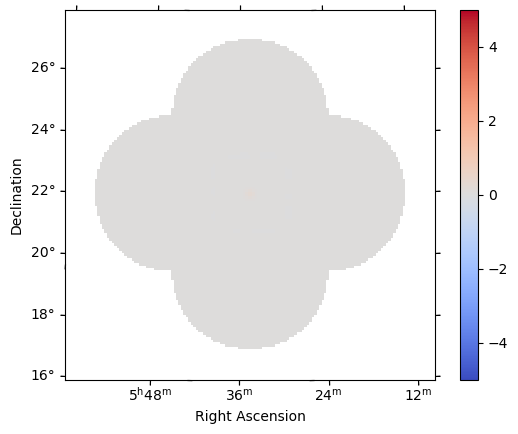

In [45]:
d = dataset_conv_N
d.plot_residuals_spatial()

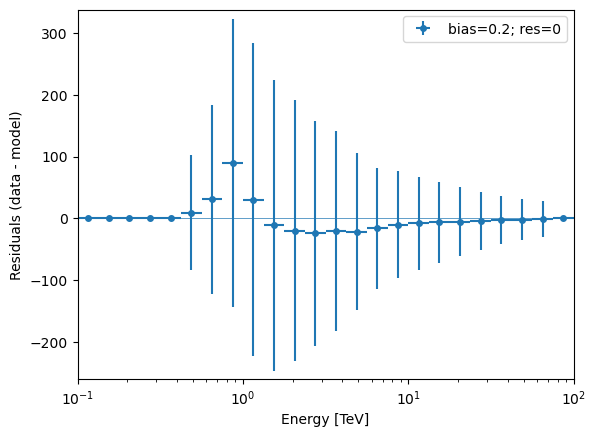

In [46]:
fig, ax = plt.subplots()
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        i += 1
ax.legend()


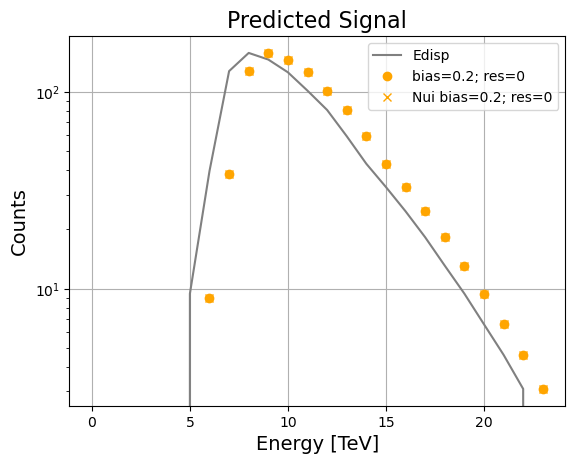

In [47]:
import matplotlib.pyplot as plt

# Your data processing code here

plt.title("Predicted Signal", fontsize=16)
i = 0 
fmts = ['o', 'x', '--', ':']
colors = ['orange', 'red', 'tab:blue', 'green']
plt.plot(sum_e(dataset_load.counts.data-dataset_load.background.data),
         label = "Edisp", color = 'grey')
npreds_pre_fit = []
npreds_pre_fit_N = []
for b in biass:
    for s in sigmass:
        npreds_pre_fit.append( sum_e(datasets_conv[i].npred_signal().data))
        npreds_pre_fit_N.append( sum_e(datasets_conv_N[i].npred_signal().data))
        
        plt.plot( sum_e(datasets_conv[i].npred_signal().data),
                 fmts[i], label = f"bias={b}; res={s}", color = colors[i])
        plt.plot( sum_e(datasets_conv_N[i].npred_signal().data),
                 'x', label = f"Nui bias={b}; res={s}", color = colors[i])
        i += 1
        
#plt.ylim(1e-1, 4e2)
plt.yscale('log')
plt.legend()
plt.xlabel("Energy [TeV]", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.grid(True)
fig = plt.gcf()
#fig.savefig(f"plots/1_Npred_bias={bias}sigma={sigma}.png", dpi=300, quality=95)

corr
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.536e+05                 │              Nfcn = 177              │
│ EDM = 0.00146 (Goal: 0.0002)     │            time = 2.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬────────

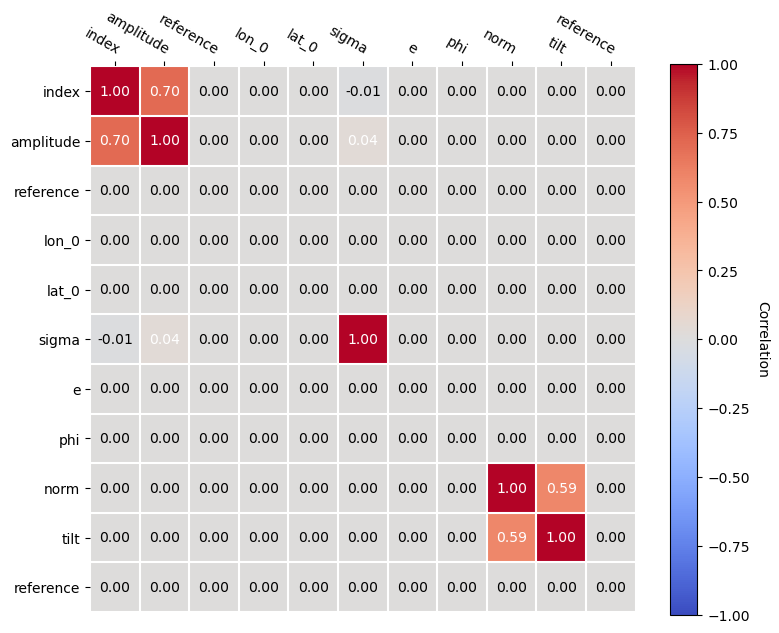

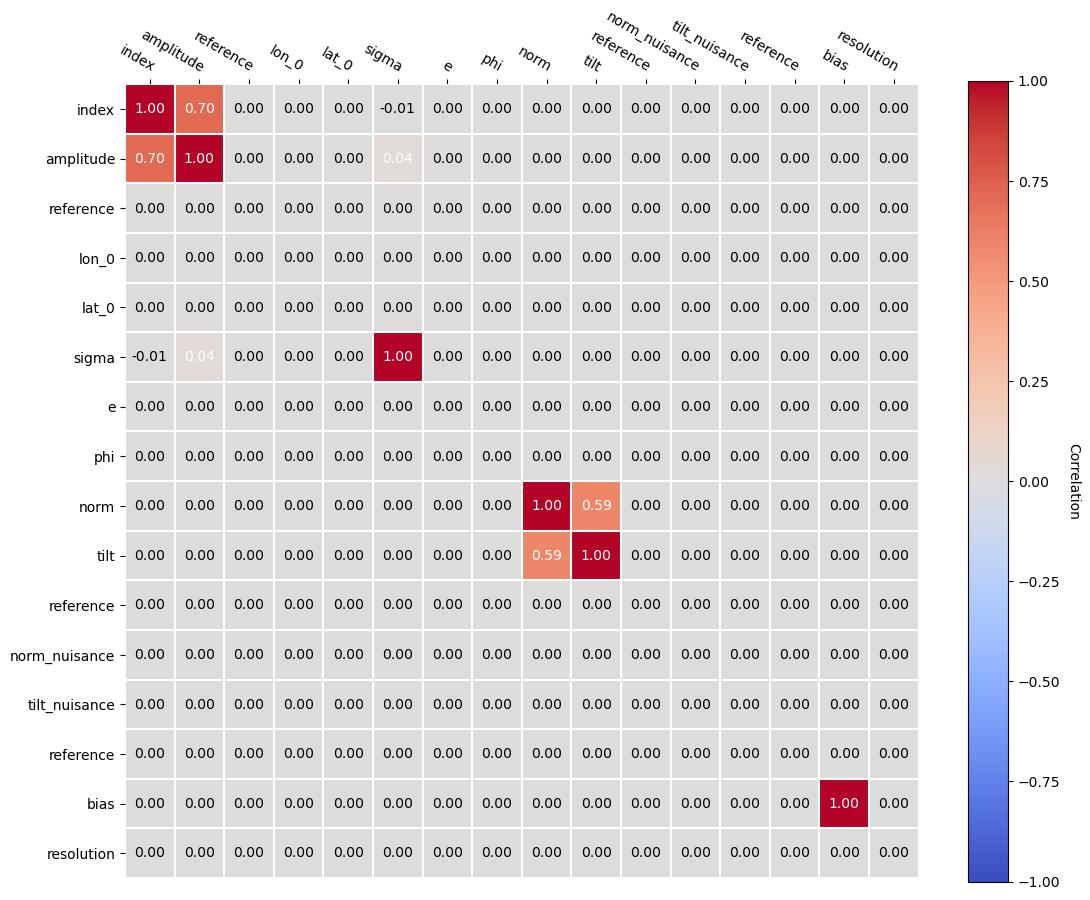

In [48]:
%%time
print("corr")
for d in datasets_conv:
    fit_cor = Fit(store_trace=False)
    minuit_opts = {"tol": 0.1, "strategy": 2}
    fit_cor.optimize_opts = minuit_opts
    result_cor = fit_cor.run(d)
    #d.models.covariance = fit_cor.covariance(d).matrix
    d.models.covariance.plot_correlation()
    print(fit_cor.minuit)

for d in datasets_conv_N:
    fit_cor_N = Fit(store_trace=False)
    fit_cor_N.optimize_opts = {"tol": 0.1, "strategy": 2}
    result_cor = fit_cor_N.run(d)
    #d.models.covariance = fit_cor_N.covariance(d).matrix
    d.models.covariance.plot_correlation()
    print(fit_cor_N.minuit)
    




        

In [49]:
fit_cor_N.minuit.parameters

('par_000_index',
 'par_001_amplitude',
 'par_002_sigma',
 'par_003_norm',
 'par_004_tilt',
 'par_005_bias')

In [50]:
fit_cor_N.minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.536e+05                 │              Nfcn = 209              │
│ EDM = 0.00146 (Goal: 0.0002)     │           time = 36.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name              │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_index     │   2.50    │   0.08    │            │            │         │         │       │
│ 1 │ par_001_amplitude │   1.07    │   0.10    │            │            │         │         │       │
│ 2 │ par_002_sigma     │    1.9    │    1.1    │            │            │    0    │         │       │
│ 3 │ par_003_norm      │  1.0004   │  0.0021   │            │            │         │         │       │
│ 4 │ par_004_tilt      │  0.0004   │  0.0020   │            │            │         │         │       │
│ 5 │ par_005_bias      │   -0.0    │    0.2    │            │            │         │         │       │
└───┴───────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                   │     par_000_index par_001_amplitude     par_002_sigma      par_003_norm      par_004_tilt      par_005_bias │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│     par_000_index │           0.00628           0.00556         -0.000766         -9.76e-06         -9.05e-06         -7.22e-12 │
│ par_001_amplitude │           0.00556           0.00994           0.00416         -1.58e-05          -4.9e-06         -6.68e-12 │
│     par_002_sigma │         -0.000766           0.00416              1.24         -4.95e-06          5.68e-06          -7.3e-11 │
│      par_003_norm │         -9.76e-06         -1.58e-05         -4.95e-06          4.26e-06          2.37e-06          1.16e-14 │
│      par_004_tilt │         -9.05e-06          -4.9e-06          5.68e-06          2.37e-06          3.85e-06          1.01e-14 │
│      par_005_bias │         -7.22e-12         -6.68e-12          -7.3e-11          1.16e-14          1.01e-14              0.04 │
└───────────────────┴─────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [51]:
print(datasets_conv_N[0].models)

DatasetModels

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.502   +/-    0.08             
    amplitude                     :   1.07e-12   +/- 1.0e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.019   +/-    0.01 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : dataset N-bkg
  Datasets names            : ['dataset N']
  Spectral model type       : PowerLawNormSpectralModel
  Paramet

In [52]:
for d in datasets_conv_N:
    for p in d.models.parameters.penalised_parameters:
        p.frozen = True
        print(p.name)

norm_nuisance
tilt_nuisance
bias
resolution


In [53]:
colors_standard = ['darkblue', 'sienna', 'darkolivegreen', 'darkred']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


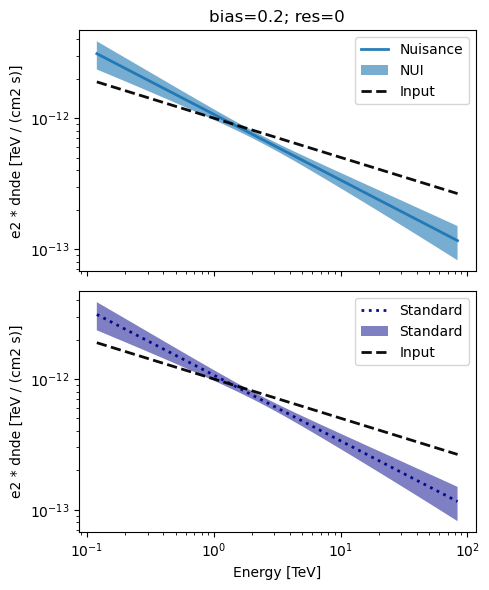

In [54]:
energy = datasets_conv[0].counts.geom.axes[0].center.value
energy_bounds = (energy[0], energy[-1] ) * u.TeV


fig,axs = plt.subplots(2,1, sharex = True, sharey=True, figsize = (5,6))
#axs = [axs]
i =0; ii =0
for b in biass:
    for s in sigmass:
        
        d = datasets_conv_N[i]
    
        d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[ii],
                                                               color=colors[ii],
                                                                 label= f"Nuisance",
                                                                alpha = 0.95,
                                                               linestyle='-', linewidth= 2)       

        d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[ii],
                                                               facecolor=colors[ii],
                                                                 label="NUI",
                                                                alpha = 0.6)
        d = datasets_conv[i]
        d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[ii+1],
                                                               color=colors_standard[ii],
                                                                 label= f"Standard",
                                                                alpha = 0.95,
                                                               linestyle=':', linewidth= 2)       

        d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[ii+1],
                                                               facecolor=colors_standard[ii],
                                                                 label="Standard",
                                                                alpha = 0.5)
        
        axs[ii].set_title(f"bias={b}; res={s}")
        i +=1
        ii +=1
for a in axs:
    dataset_load.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = a,
                                                               color='black',
                                                                 label="Input",
                                                                alpha = 0.95,
                                                               linestyle='dashed', linewidth= 2)  
    a.legend()
    
ylim = axs[0].get_ylim()
axs[0].set_xlabel('')
plt.tight_layout()


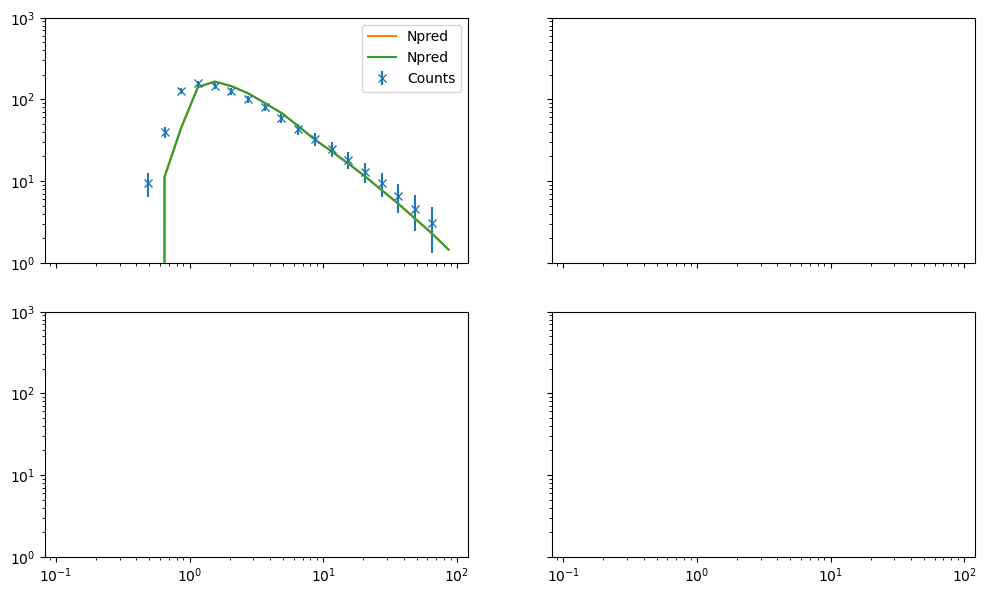

In [55]:
fig,axs = plt.subplots(2,2, sharex = True, sharey=True, figsize = (12,7))
axs = axs.flatten()
i =0; ii =0
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        axs[ii].errorbar(energy, sum_e(d.counts.data-d.background.data), 
                     yerr = np.sqrt(sum_e(d.counts.data-d.background.data)),
                    fmt = 'x', label = "Counts")

        axs[ii].plot(energy, sum_e(d.npred_signal().data), label = "Npred")
        d = datasets_conv[i]
        axs[ii].plot(energy, sum_e(d.npred_signal().data), label = "Npred")
        
        axs[ii].loglog()
        axs[ii].legend()
        axs[ii].set_ylim(1e0, 1e3)        
        ii +=1
        


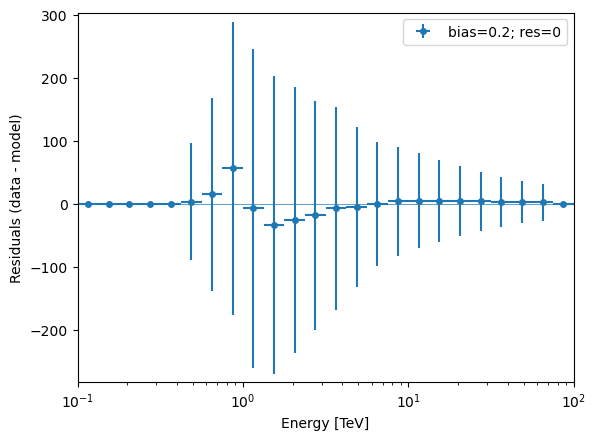

In [56]:
fig, ax = plt.subplots()
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        i += 1
ax.legend()


['B=0.2;\n R=0']


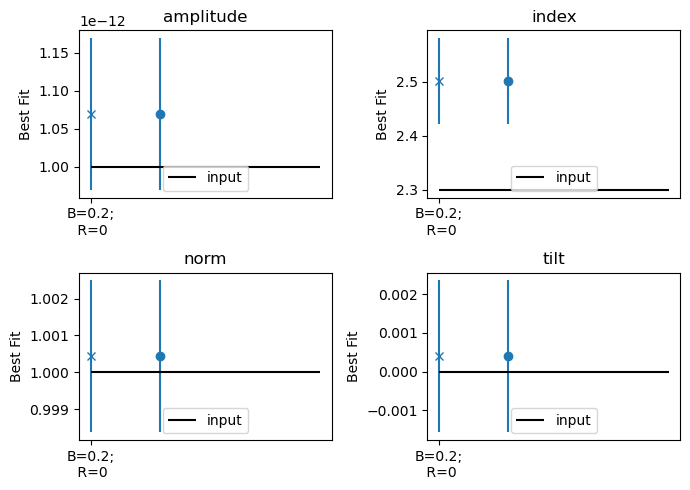

In [57]:
fig,ax  = plt.subplots(2,2,figsize= (7, 5))
ax = ax.flatten()
parnames = ['amplitude', 'index', 'norm', 'tilt']
labels_sys = []

ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'x', color = colors[ii])
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii+0.3, value, yerr = error, fmt = 'o', color = colors[ii])
        ii +=1
        labels_sys.append(f'B={b};\n R={s}')
print(labels_sys)        
for i, p in enumerate(parnames):
    value = dataset_load.models.parameters[p].value
    error = dataset_load.models.parameters[p].error    
    #ax[i].errorbar(4, value, yerr = error, fmt = 'x')
    ax[i].hlines( value, 0, len(datasets_conv), label = "input", color= 'black')
    ax[i].set_title(p)
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='lower center',)# bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    #ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(len(datasets_conv)),labels_sys)
    
plt.tight_layout()
    

['B=0.2;\n R=0']


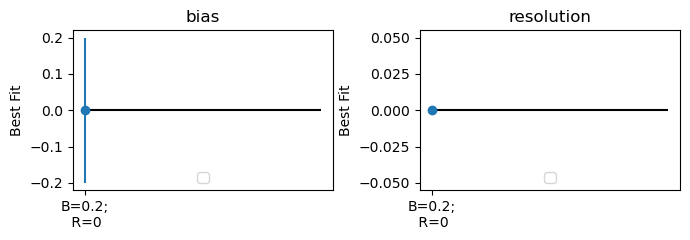

In [58]:
fig,ax  = plt.subplots(1,2,figsize= (7, 2.5))
ax = ax.flatten()
parnames = ['bias', 'resolution',]
labels_sys = []

ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'o', color = colors[ii])
            ax[i].set_title(p)
            
        ii +=1
        labels_sys.append(f'B={b};\n R={s}')
        
print(labels_sys)        
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='lower center',)# bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    #ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(len(datasets_conv)),labels_sys)
    ax.hlines( 0, 0., 3., label = "input", color= 'black')
    
plt.tight_layout()
    

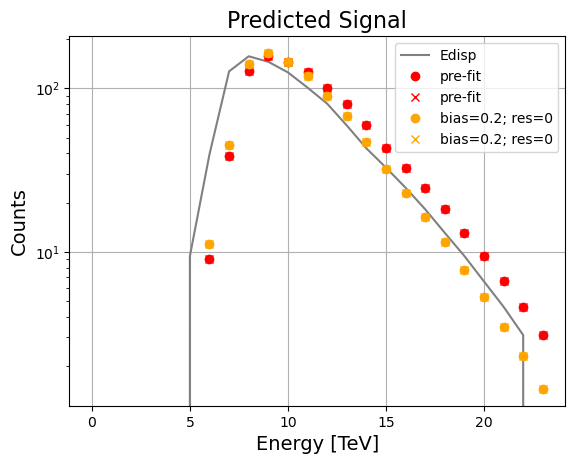

In [59]:
import matplotlib.pyplot as plt

# Your data processing code here

plt.title("Predicted Signal", fontsize=16)
i = 0 
fmts = ['o', 'x', '--', ':']
colors = ['orange', 'red', 'tab:blue', 'green']
plt.plot(sum_e(dataset_load.counts.data-dataset_load.background.data),
         label = "Edisp", color = 'grey')
for b in biass:
    for s in sigmass:
        plt.plot( npreds_pre_fit[i],
                 fmts[i], label = f"pre-fit", color = colors[i+1])
        plt.plot( npreds_pre_fit_N[i],
                 'x', label = f"pre-fit", color = colors[i+1])
        
        plt.plot( sum_e(datasets_conv[i].npred_signal().data),
                 fmts[i], label = f"bias={b}; res={s}", color = colors[i])
        plt.plot( sum_e(datasets_conv_N[i].npred_signal().data),
                 'x', label = f"bias={b}; res={s}", color = colors[i])
        i += 1
        
#plt.ylim(1e-1, 4e2)
plt.yscale('log')
plt.legend()
plt.xlabel("Energy [TeV]", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.grid(True)
fig = plt.gcf()
#fig.savefig(f"plots/1_Npred_bias={bias}sigma={sigma}.png", dpi=300, quality=95)

In [60]:
x_N, y_N = fit_cor_N.minuit.profile("par_000_index")
x, y = fit_cor.minuit.profile("par_000_index")



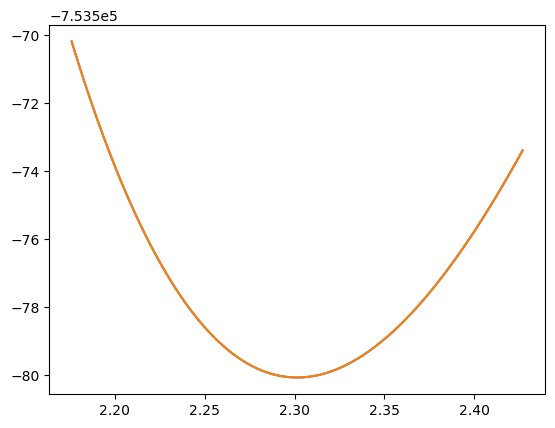

In [26]:
plt.plot(x, y, label = 'standard');
plt.plot(x_N, y_N, label = 'Nui');